In [1]:
# !pip install tensorflow
# !pip install torch
# #!conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
# !conda install -c pyg pyg --y

In [2]:
# !conda remove pytorch --y

In [3]:
# !conda install pytorch==1.10.0 torchvision==0.11.0 torchaudio==0.10.0 cudatoolkit=10.2 -c pytorch --y
# !conda install pytorch-sparse -c pyg --y
# !conda install pyg -c pyg -c conda-forge --y

In [4]:
import os
from generate_points import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC,Precision,Recall,BinaryCrossentropy,Accuracy
import networkx as nx
import torch
from torch_geometric.utils import *
from torch import Tensor
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('Not found')
print('Found GPU at: {}'.format(device_name))

2022-10-03 19:50:32.639904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 19:50:32.803743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-03 19:50:32.803763: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-03 19:50:32.833504: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-03 19:50:33.834897: W tensorflow/stream_executor/platform/de

Not found
Found GPU at: 


2022-10-03 19:50:35.984549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 19:50:35.985083: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-03 19:50:35.985102: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-03 19:50:35.985124: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (felipe-Inspiron-5448): /proc/driver/nvidia/version does not exist


In [5]:
P = np.zeros((3,3))

In [6]:
P

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [7]:
# P[0,0] = 0.8
# P[0,1] = 0.2
# P[0,2] = 0.2
# P[1,1] = 0.8
# P[1,2] = 0.2
# P[2,2] = 0.8
P = np.array([[0.8, 0.2, 0.3],[0.2, 0.7, 0.4],[0.3, 0.4, 0.6]])
# P = P + P.T - np.diag(P.diagonal())

In [8]:
P

array([[0.8, 0.2, 0.3],
       [0.2, 0.7, 0.4],
       [0.3, 0.4, 0.6]])

In [9]:
k = 0
K = 3
n = 33

In [10]:
## ENTRADA: P - Matriz de probabilidades do SBM, K - Numero de comunidades
## SAIDA: DICIONARIO CONTENDO OS VETORES PARA TODAS AS COMBINAÇÕES DE COMUNIDADES i e j
## Ex: basis[i][j] determina o vetor que codifica a relação entre a comunidade i e a j para i<j. 
## Se i>j, toma-se o vetor basis[j][i] espelhado pela reta identidade
def make_basis(P,K):
    basis = {}
    for i in range(K):
#         basis.append({})
        basis[i] = {}
        for j in range(i,K):
            alpha = 0
            alpha = np.arccos(P[i,j])
            if i == j:## COLOCA OS DOIS VETORES PARA FORMAR A BASE
                basis[i][j] = []
                v = np.array([np.cos(np.pi/4 - alpha/2),np.sin(np.pi/4 - alpha/2)])
                basis[i][j].append(v)
                v = np.array([np.sin(np.pi/4 - alpha/2),np.cos(np.pi/4 - alpha/2)])
                basis[i][j].append(v)
            else:## ESCOLHE ALEATORIAMENTE UM DOS VETORES
                u = np.random.uniform(0,1)
                v = np.zeros(2)
                if u > 0.5:
                    v = np.array([np.cos(np.pi/4 - alpha/2),np.sin(np.pi/4 - alpha/2)])
                else:
                    v = np.array([np.sin(np.pi/4 - alpha/2),np.cos(np.pi/4 - alpha/2)])
                basis[i][j]=v 
    return basis

In [11]:
## ENTRADA basis - dicionario de vetores, K - Número de comunidades, n o número de amostras e 
## delta o tamanho do vetor
## SAIDA: Uma matriz (n*K x 2*K) contendo as representações de todos os vértices
def make_vectors(basis,K,n,delta):
    X = np.zeros((K*n,2*K))
    for c in range(K): ## PARA CADA UMA DAS COMUNIDADES
        for i in range(n):## PARA CADA VÉRTICE DE UMA COMUNIDADE
            for j in range(K):## PARA CADA POSIÇÃO NO VETOR DE CARACTERÍSTICAS
                r = np.random.uniform(1,delta)
                if j<c:
                    X[i+n*c][2*j:2*j+2] = r*np.flip(basis[j][c])
                elif j==c:
                    u = np.random.uniform(0,1)
                    v = np.zeros(2)
                    if u > 0.5:
                        v = r*basis[j][c][1]
                    else:
                        v = r*basis[j][c][0]
                    X[i+n*c][2*j:2*j+2] = v
                else:
                    X[i+n*c][2*j:2*j+2] = r*basis[c][j]
    return X

In [12]:
basis = make_basis(P,K)
delta=1
X = make_vectors(basis,K,n,delta)

In [13]:
for i in range(K):
    for j in range(i,K):
        a = np.arccos(P[i,j])
        print(np.cos(np.pi/4-a/2),np.sin(np.pi/4-a/2))

0.8944271909999159 0.447213595499958
0.9949361530051241 0.1005089620052081
0.9884177258166068 0.15175769928253113
0.9257815192728479 0.3780589617676818
0.9789063129307033 0.20430964368921994
0.9486832980505138 0.3162277660168379


In [14]:
basis

{0: {0: [array([0.89442719, 0.4472136 ]), array([0.4472136 , 0.89442719])],
  1: array([0.99493615, 0.10050896]),
  2: array([0.98841773, 0.1517577 ])},
 1: {1: [array([0.92578152, 0.37805896]), array([0.37805896, 0.92578152])],
  2: array([0.20430964, 0.97890631])},
 2: {2: [array([0.9486833 , 0.31622777]), array([0.31622777, 0.9486833 ])]}}

## Traditional Neural Networks Embedding

In [15]:
## Treinamento não supervisionado
def get_Autoencoder(input_shape):
    model = Sequential()
    model.add(layers.Dense(input_shape,activation='relu',input_shape=(input_shape,) ))
    model.add(layers.Dense(2,activation='relu'))
    model.add(layers.Dense(input_shape,activation='relu'))
    model.compile(optimizer=opt,loss='MSE')
    return model

In [16]:
## Trainamento supervisionado 
def get_ANN(input_shape):
    model = Sequential()
    model.add(layers.Dense(input_shape,activation='relu',input_shape=(input_shape,) ))
    model.add(layers.Dense(2,activation='relu'))
    model.add(layers.Dense(3,activation='softmax'))
    model.compile(optimizer=opt,loss='CategoricalCrossentropy')
    return model

In [17]:
opt = tf.keras.optimizers.Nadam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999,
    name='NAdam'
)

In [18]:
## Extrai as representações obtidas após passar pela camada com 2 neurônios
## Entrada: up_to - numero da camada da qual se deseja obter as representações, model - modelo de rede neural
def getExtractionModel(up_to=1,model=None):
    extractor = Sequential()
    for i in range(up_to):
        extractor.add(model.layers[i])
    return extractor

In [19]:
## Onehot encoding das classes
y = np.hstack([np.ones(n,dtype=np.int16)*i for i in range(K)])
Y = np.zeros((y.size, y.max()+1))
Y[np.arange(y.size),y] = 1

In [20]:
## Obtem o embedding dependendo se for com autoencoder ou não
def NN_embedding(X,Y,autoencoder=False):
    model= None
    if autoencoder:
        model = get_Autoencoder((X.shape[1]))
        model.fit(X,X,epochs=100,shuffle=True,verbose=0)
    else:
        model = get_ANN((X.shape[1]))
        model.fit(X,Y,epochs=100,shuffle=True,verbose=0)
    encode = getExtractionModel(up_to=2,model=model)
    X_t = np.array(encode.predict(X))
    return X_t

In [21]:
X.dtype

dtype('float64')

## Graph Neural Networks Embedding

In [22]:
## Obtem a rede pelo SBM e adciona os tributos
def make_graph_data(X):
    G = nx.stochastic_block_model([n]*K,P,seed=42)
    for i in range(n*K):
        G.nodes[i]["attr"] = X[i,:]
    graph_data = from_networkx(G,group_node_attrs=['attr'])
    return graph_data

In [23]:
## GNN propriamente dita
class GCN(torch.nn.Module):
    def __init__(self,n_feat):
        super().__init__()
        self.conv1 = GCNConv(n_feat, 2)
#         self.conv2 = GCNConv(16,2)
        self.mlp = torch.nn.Linear(2,K)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
#         x = F.relu(x)
        x = self.mlp(x)
        return F.log_softmax(x, dim=1)

In [24]:
## Treino da GNN
def train_model(model,graph_data,Y,epochs=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    out = total = 0
    graph_data.x = Tensor.float(graph_data.x)
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    target = Tensor(Y)
    while total < epochs:
        optimizer.zero_grad()
        out = model(graph_data)
        loss = loss_fn(out,target)
        loss.backward()
        optimizer.step()
        total += 1

In [25]:
## Obtem a representação da GNN da penúltima camada
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [26]:
def make_GNN_embedding(X,Y):
    graph_data = make_graph_data(X)
    model = GCN(graph_data.num_node_features)
    train_model(model,graph_data,Y)
    model.conv1.register_forward_hook(get_activation('conv1'))
    out = model(graph_data)
    X_t = F.relu(activation["conv1"]).detach().numpy()
    return X_t

In [27]:
def make_plot(X_t,title,delta,folder,n=n):
    plt.scatter(X_t[:n,0],X_t[:n,1],label="1")
    plt.scatter(X_t[n:2*n,0],X_t[n:2*n,1],label="2")
    plt.scatter(X_t[2*n:3*n,0],X_t[2*n:3*n,1],label="3")
    plt.legend()
    plt.title(title)
    plt.savefig(folder+"/embedding_"+title+f"_delta_{delta}.png")
    plt.show()

---------------- Delta = 1.0 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


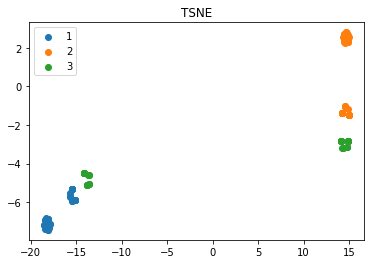

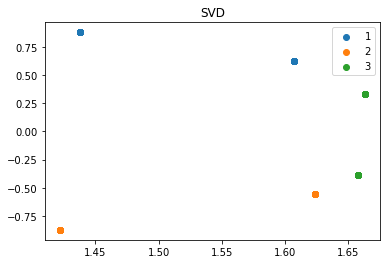

---------------- Delta = 3.25 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


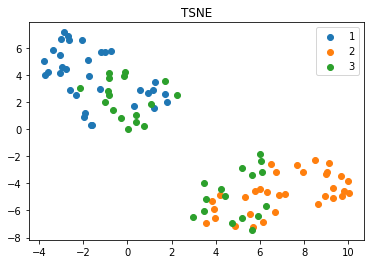

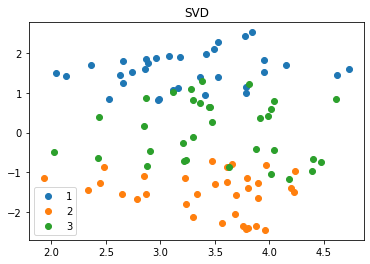

---------------- Delta = 5.5 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


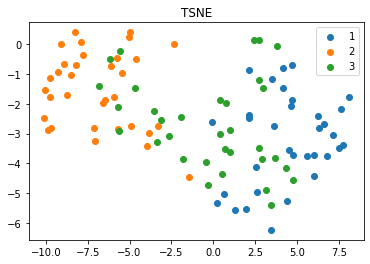

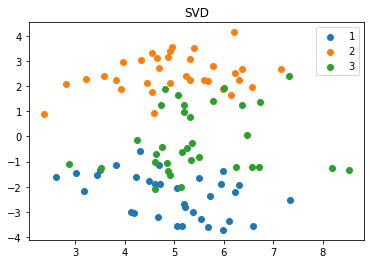

---------------- Delta = 7.75 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


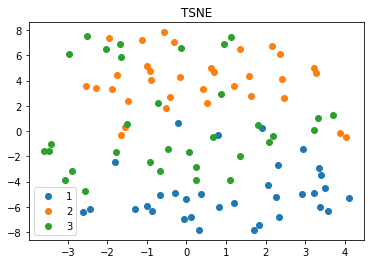

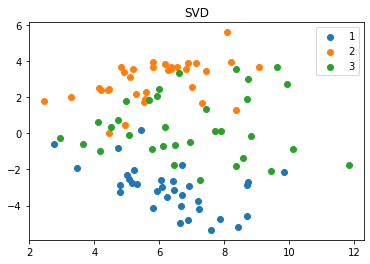

---------------- Delta = 10.0 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


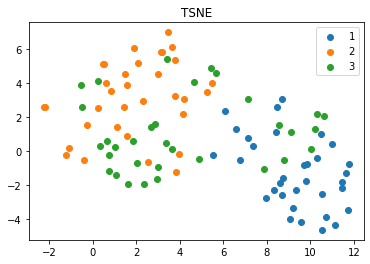

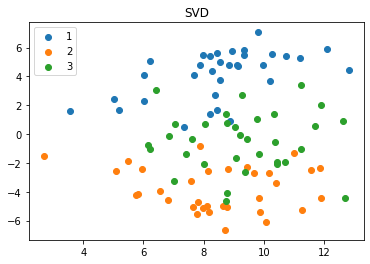

---------------- Delta = 20 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


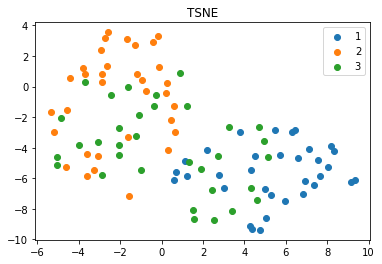

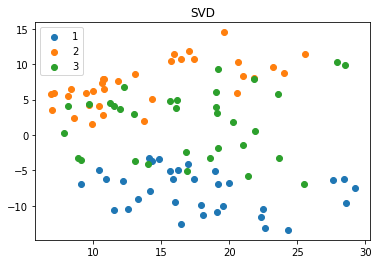

---------------- Delta = 30 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


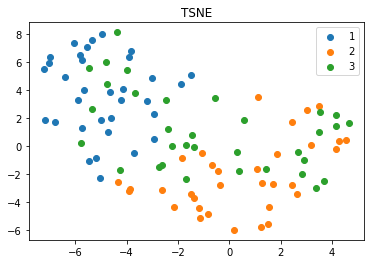

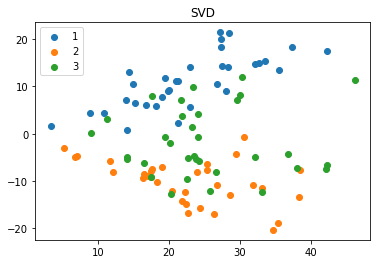

---------------- Delta = 40 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


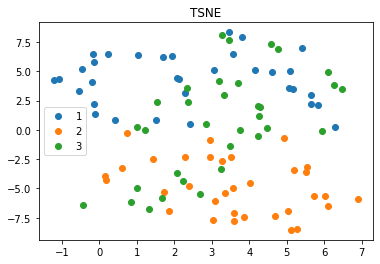

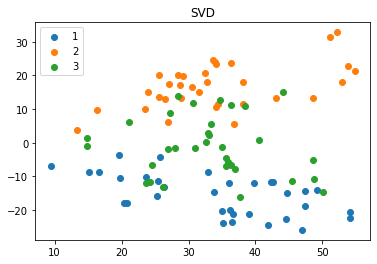

---------------- Delta = 60 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


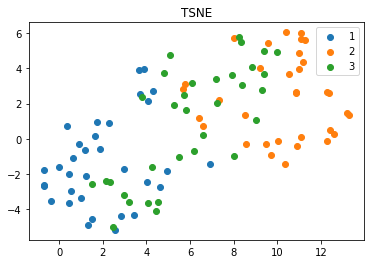

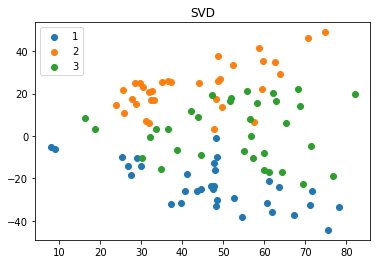

---------------- Delta = 80 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


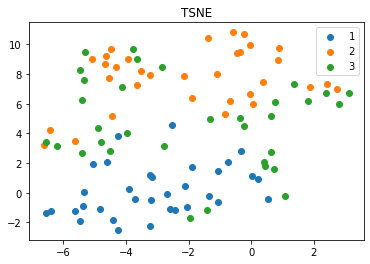

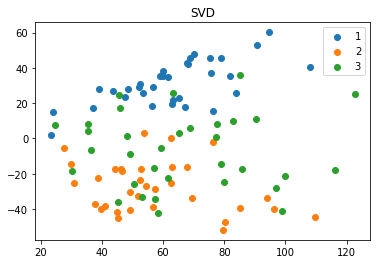

---------------- Delta = 100 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


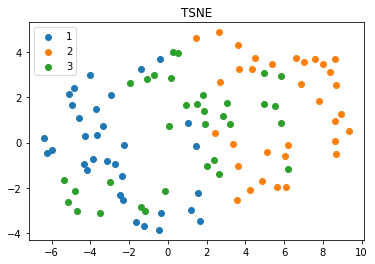

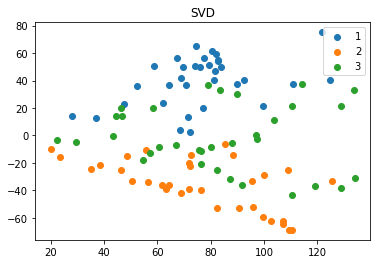

In [28]:
 def run_test(basis,K,n,make_vectors,folder):
    deltas = np.linspace(1,10,5).tolist()
    deltas.extend([20,30,40,60,80,100])
    exists = os.path.exists("./"+folder)
    if not exists:
        os.mkdir("./"+folder)
    for delta in deltas:
        print(f"---------------- Delta = {delta} -------------------")
        X = make_vectors(basis,K,n,delta)
        X_t = TSNE().fit_transform(X)
        make_plot(X_t,"TSNE",delta,folder)
        X_t = TruncatedSVD().fit_transform(X)
        make_plot(X_t,"SVD",delta,folder)
    #     X_t = NN_embedding(X,Y)
    #     make_plot(X_t,"Autoencoder",delta)
    #     X_t = make_GNN_embedding(X,Y)
    #     make_plot(X_t,"GNN",delta)
run_test(basis,K,n,make_vectors,"Teste1")

/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


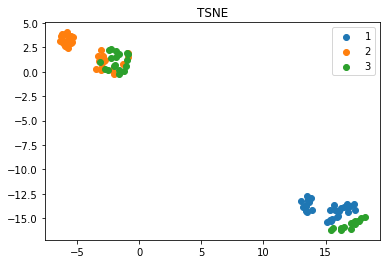

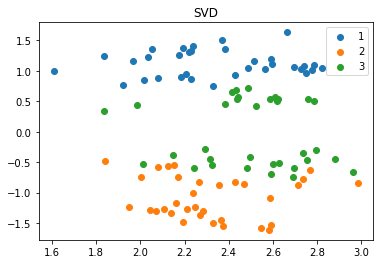

In [29]:
delta = 2
X = make_vectors(basis,K,n,delta)
X_t = TSNE().fit_transform(X)
make_plot(X_t,"TSNE",delta,"Teste1")
X_t = TruncatedSVD().fit_transform(X)
make_plot(X_t,"SVD",delta,"Teste1")

### Confirmação da hipótese: Os 6 pontos encontrados pelo SVD e TSNE são por conta das duas representações dentro da mesma classe

In [30]:
def make_vectors_hypothesis(basis,K,n,delta):
    X = np.zeros((2*K*n,2*K)) ##dobra o numero de vertices sendo que para os primeiros n vetores 
    #de uma comunidade os atributos dos vértices da mesma comunidade c será codificado usando basis[c][c][0]
    #e a outra parte utilizando basis[c][c][1]
    for c in range(K): ## PARA CADA UMA DAS COMUNIDADES
        for i in range(n):## PARA CADA VÉRTICE DE UMA COMUNIDADE
            for j in range(K):## PARA CADA POSIÇÃO NO VETOR DE CARACTERÍSTICAS
                r = np.random.uniform(1,delta)
                if j<c:
                    X[i+2*n*c, 2*j:2*j+2] = r*np.flip(basis[j][c])
                elif j==c:
                    v = r*basis[j][c][0]
                    X[i+2*n*c, 2*j:2*j+2] = v
                else:
                    X[i+2*n*c, 2*j:2*j+2] = r*basis[c][j]
        ## Obtem o vetor refletido para a mesma comunidade e copia os demais atributos
        v = r*basis[c][c][1]
        X[2*n*c + n:2*n*(c+1), :] = X[2*n*c:2*n*c+n,:]
        X[2*n*c+n:2*n*(c+1), 2*c:2*c+2] = v
    return X

In [31]:
##plot incluindo o vetor que codifica a relação intraclasse
def make_plot_hypothesis(X,X_t,title,delta,K,n=n):
    m=n//2
    for i in range(K):
        plt.scatter(X_t[2*m*i:2*m*i+2*m,0],X_t[2*m*i:2*m*i+2*m,1],label=f"{i+1}")
        plt.annotate(f"{X[2*m*i,2*i:2*i+2]}",X_t[2*m*i])
        plt.annotate(f"{X[2*m*i+m,2*i:2*i+2]}",X_t[2*m*i+m])
    plt.legend()
    plt.title(title)
    plt.savefig("embedding_"+title+f"$\delta$_{delta}.png")
    plt.show()

In [32]:
delta=1
X = make_vectors_hypothesis(basis,K,n//2,delta)

/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


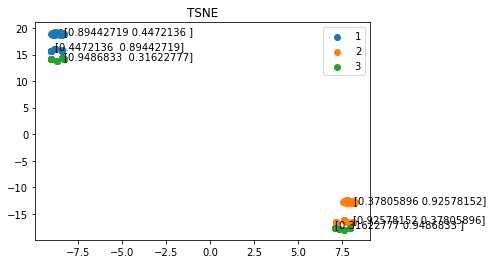

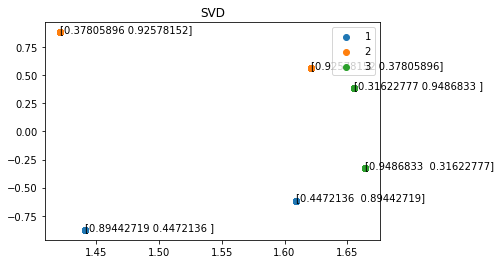

In [33]:
X_t = TSNE().fit_transform(X)
make_plot_hypothesis(X,X_t,"TSNE",delta,K,n)
X_t = TruncatedSVD().fit_transform(X)
make_plot_hypothesis(X,X_t,"SVD",delta,K,n)

In [34]:
## ENTRADA basis - dicionario de vetores, K - Número de comunidades, n o número de amostras,
## delta o tamanho do vetor e a matriz de probabilidades P do SBM
## SAIDA: Uma matriz (n*K x 2*K) contendo as representações de todos os vértices
## Nessa versão a codificação da mesma classe é feita por uma gaussiana multivariada cujo std é dado pela delta x p_i_j
def make_vectors_2(basis,K,n,delta,P=P):
    X = np.zeros((K*n,2*K))
    for c in range(K): ## PARA CADA UMA DAS COMUNIDADES
        for i in range(n):## PARA CADA VÉRTICE DE UMA COMUNIDADE
            for j in range(K):## PARA CADA POSIÇÃO NO VETOR DE CARACTERÍSTICAS
                r = np.random.uniform(1,delta)
                if j<c:
                    X[i+n*c][2*j:2*j+2] = r*np.flip(basis[j][c])
                elif j==c:
                    X[i+n*c][2*j:2*j+2] = np.random.multivariate_normal(np.array([0]*2),np.diag([delta*(1-P[j][j])]*2))
                else:
                    X[i+n*c][2*j:2*j+2] = r*basis[c][j]
    return X

---------------- Delta = 1.0 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


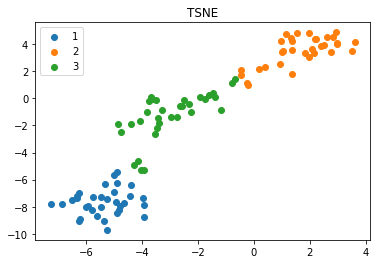

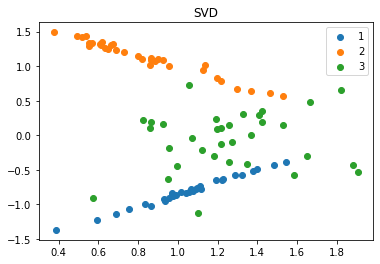

---------------- Delta = 3.25 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


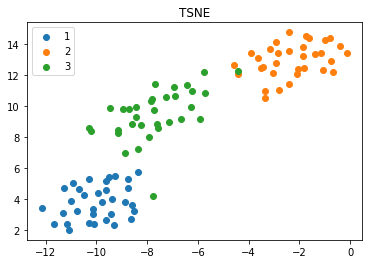

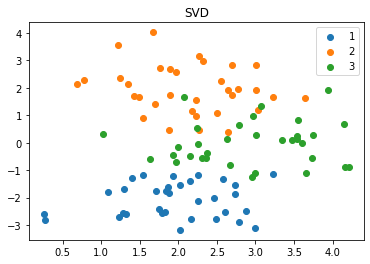

---------------- Delta = 5.5 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


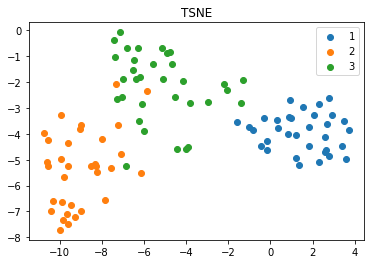

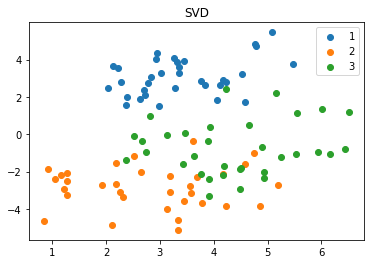

---------------- Delta = 7.75 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


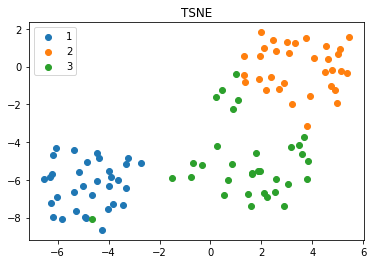

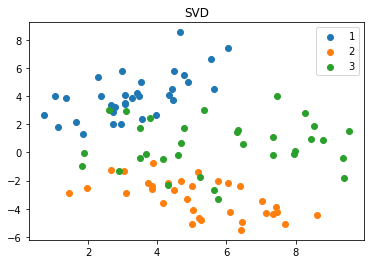

---------------- Delta = 10.0 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


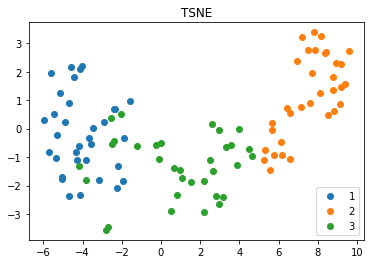

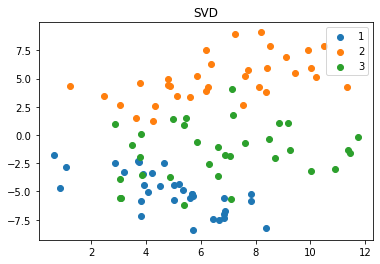

---------------- Delta = 20 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


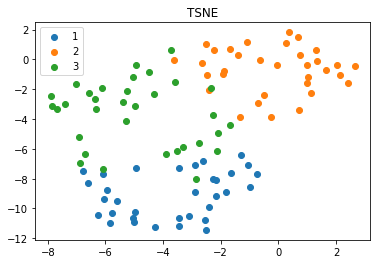

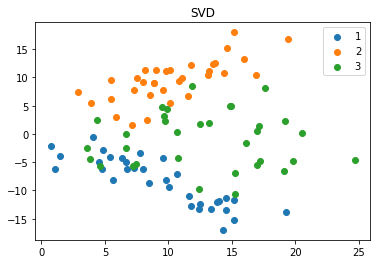

---------------- Delta = 30 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


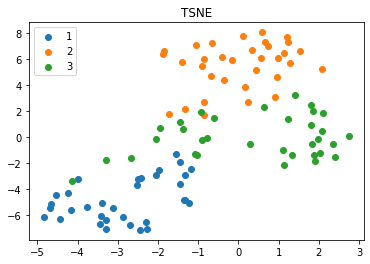

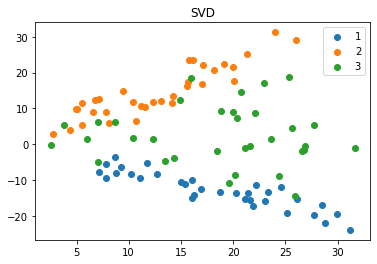

---------------- Delta = 40 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


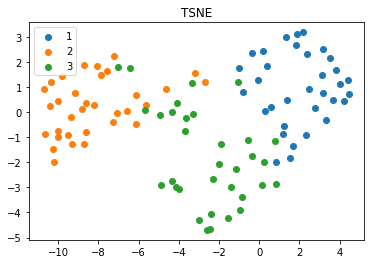

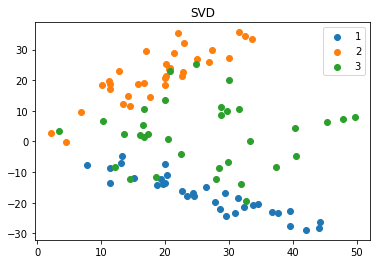

---------------- Delta = 60 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


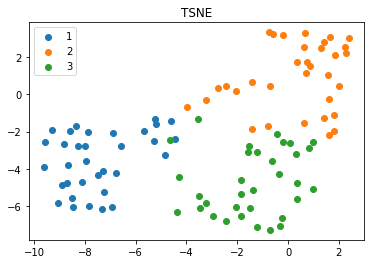

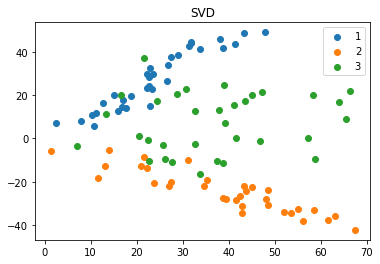

---------------- Delta = 80 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


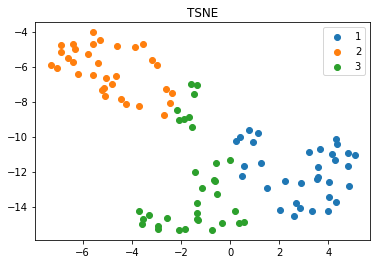

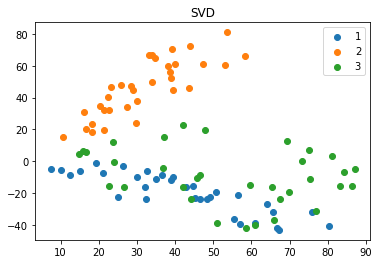

---------------- Delta = 100 -------------------


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


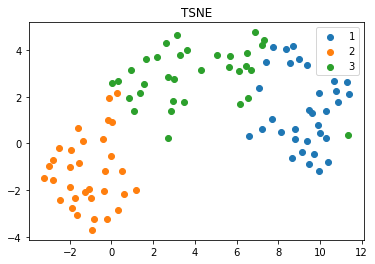

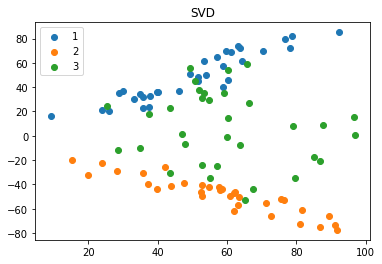

In [35]:
run_test(basis,K,n,make_vectors_2,"Teste2")

In [48]:
## Nessa versão as bases são criadas a partir de normais multivariadas
def make_basis_2(P,K,delta,dim=2,sample_along_direction=True):
    basis = {}
    if sample_along_direction:
        directions = []
        for _ in range(K):
            ### amostragem de uma direção aleatoria
            directions.append(generate_point_on_sphere(dim))
        print(directions)
        for i in range(K):
            basis[i] = {}
            for j in range(i,K):
                ### a escalagem do vetor depende da afinidade com a classe
                basis[i][j] = directions[j]*delta*(1-P[i][j])
    else:
        for i in range(K):
            basis[i] = {}
            for j in range(i,K):
                ### amostragem aleatoria do centro a partir de uma normal de media 0 sigma (1-P[i][j])*delta
                basis[i][j] = np.random.multivariate_normal(np.array([0]*dim),np.diag([delta*(1-P[i][j])]*dim))
    return basis

In [49]:
## ENTRADA K - Número de comunidades, n o número de amostras e 
## delta o tamanho do vetor
## SAIDA: Uma matriz (n*K x 2*K) contendo as representações de todos os vértices
## Nessa versão a codificação de todas as classes é feita por uma gaussiana multivariada cujo std é dado pela delta x p_i_j
def make_vectors_3(basis,K,n,delta,P=P):
    X = np.zeros((K*n,2*K))
    basis = make_basis_2(P,K,delta)
    for c in range(K): ## PARA CADA UMA DAS COMUNIDADES
        for i in range(n):## PARA CADA VÉRTICE DE UMA COMUNIDADE
            for j in range(K):## PARA CADA POSIÇÃO NO VETOR DE CARACTERÍSTICAS
                X[i+n*c][2*j:2*j+2] = np.random.multivariate_normal(basis[min(c,j)][max(c,j)],np.eye(2)) 
    return X

---------------- Delta = 1.0 -------------------
[array([0.85417607, 0.51998388]), array([0.69946019, 0.71467156]), array([-0.19353843, -0.98109269])]


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


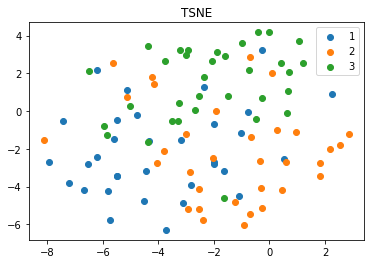

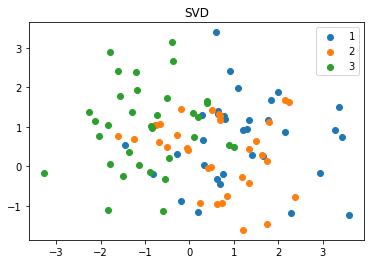

---------------- Delta = 3.25 -------------------
[array([ 0.72496379, -0.68878698]), array([-0.6238939 ,  0.78150906]), array([-0.6955439,  0.7184836])]


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


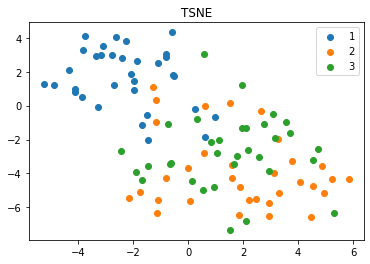

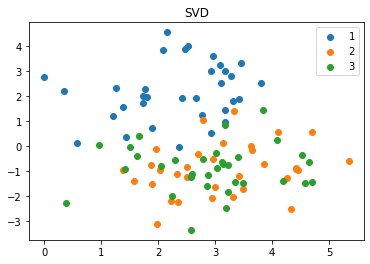

---------------- Delta = 5.5 -------------------
[array([-0.98716072,  0.15973011]), array([0.15871521, 0.98732441]), array([0.42769974, 0.90392087])]


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


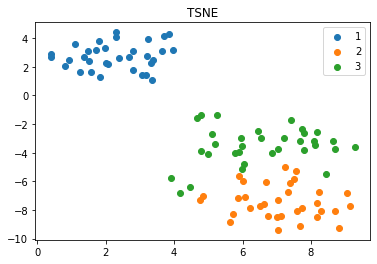

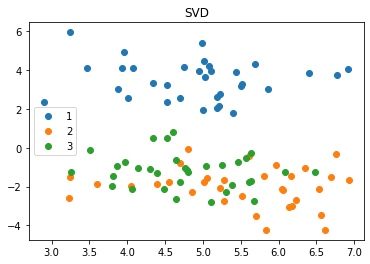

---------------- Delta = 7.75 -------------------
[array([0.83859367, 0.54475743]), array([-0.66359045, -0.74809606]), array([ 0.99946454, -0.03272067])]


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


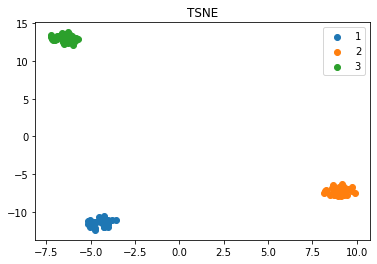

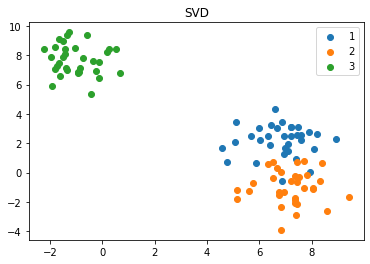

---------------- Delta = 10.0 -------------------
[array([-0.98790201, -0.15507943]), array([ 0.94405914, -0.32977621]), array([-0.25546559, -0.96681815])]


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


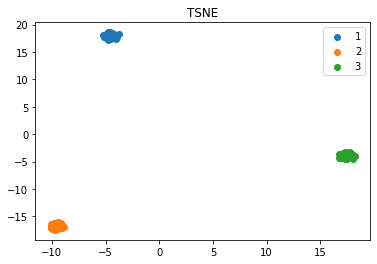

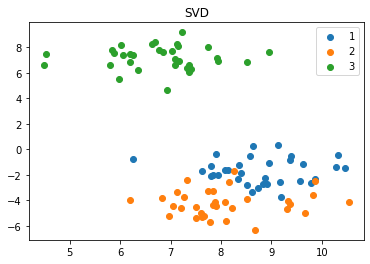

---------------- Delta = 20 -------------------
[array([-0.98886805, -0.14879511]), array([0.09557958, 0.99542179]), array([-0.99911796, -0.0419916 ])]


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


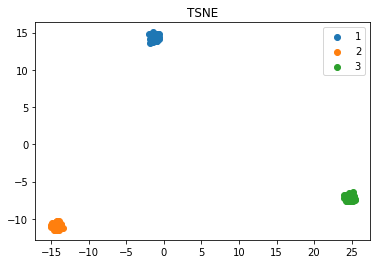

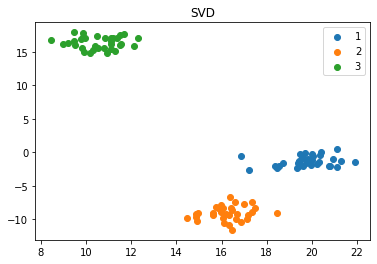

---------------- Delta = 30 -------------------
[array([-0.93716301, -0.34889181]), array([ 0.64238476, -0.76638229]), array([-0.44174965, -0.89713837])]


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


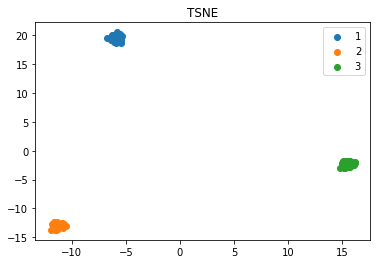

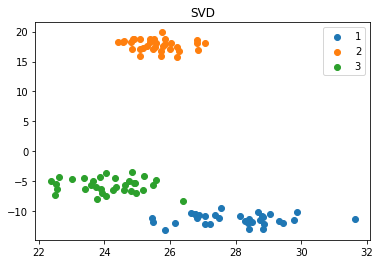

---------------- Delta = 40 -------------------
[array([-0.90681916,  0.42151987]), array([ 0.91109806, -0.41218967]), array([-0.63945985,  0.76882449])]


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


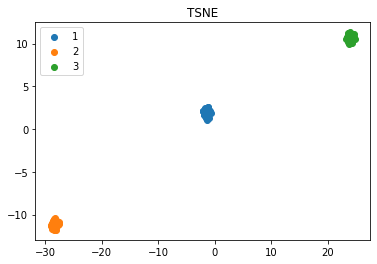

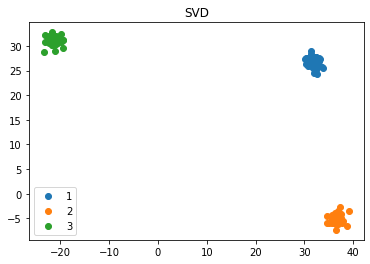

---------------- Delta = 60 -------------------
[array([0.83382595, 0.55202744]), array([ 0.97643525, -0.21581058]), array([-0.3676679 ,  0.92995716])]


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


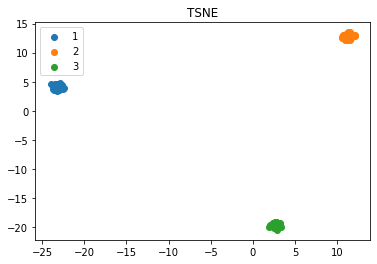

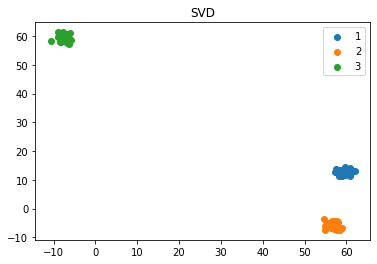

---------------- Delta = 80 -------------------
[array([0.31649521, 0.94859411]), array([-0.94564175,  0.32521022]), array([-0.89160633,  0.45281138])]


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


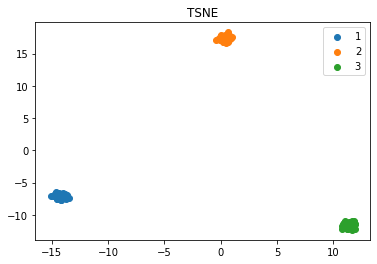

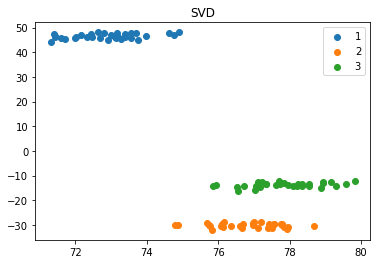

---------------- Delta = 100 -------------------
[array([ 0.75812842, -0.65210528]), array([ 0.95692011, -0.29035133]), array([ 0.26817106, -0.96337131])]


/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


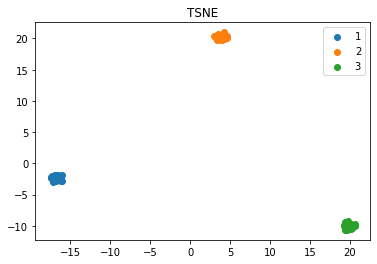

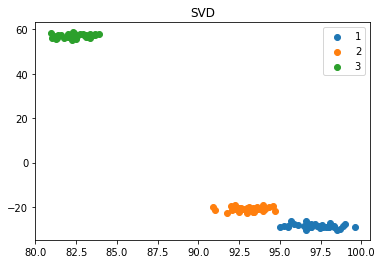

In [50]:
run_test(basis,K,n,make_vectors_3,"Teste3")

In [ ]:
delta = 0.5
X = make_vectors_3(basis,K,n,delta)
X_t = TSNE().fit_transform(X)
make_plot(X_t,"TSNE",delta,"Teste3")
X_t = TruncatedSVD().fit_transform(X)
make_plot(X_t,"SVD",delta,"Teste3")